<img src="https://trac.sdss.org/chrome/site/sdss.png", width=300, height=300>

I was searching for an astronomy dataset on Kaggle and came across this project (https://www.kaggle.com/lucidlenn/data-analysis-and-classification-using-xgboost).  I'd like to give credit to Lennart Grosser for a couple of the plots that I use in this notebook.

## Getting the data

I used the CasJobs website which offers a SQL-based interface to query the databases that contain the SDSS data. The CasJobs system allows you to save the data returned from the query in csv format.

For more information about how to get data from the SDSS see their Data Access Guide:

http://www.sdss.org/dr14/data_access/

I used the following query to retreive the data:

<font size="2">SELECT TOP 100000<br> 
p.objid,<br>
p.ra,<br>
p.dec,<br>
p.cModelMag_u,<br>
p.cModelMag_g,<br>
p.cModelMag_r,<br>
p.cModelMag_i,<br>
p.cModelMag_z,<br>
p.modelMag_u,<br>
p.modelMag_g,<br>
p.modelMag_r,<br>
p.modelMag_i,<br>
p.modelMag_z,<br>
p.psfMag_u,<br>
p.psfMag_g,<br>
p.psfMag_r,<br>
p.psfMag_i,<br>
p.psfMag_z,<br>
p.petroMag_u,<br>
p.petroMag_g,<br>
p.petroMag_r,<br>
p.petroMag_i,<br>
p.petroMag_z,<br>
s.specobjid,<br>
s.class,<br>
s.z as redshift<br> 
FROM PhotoObj AS p <br>
JOIN SpecObj AS s ON s.bestobjid = p.objid <br>
WHERE <br>
p.cModelMagErr_u BETWEEN 0 AND 0.5 <br>
AND g BETWEEN 0 AND 20<br></font>

In [72]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

#import xgboost as xgb
import seaborn as sns
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions

sns.set_style('whitegrid')

## Import the data

Define the columns that we'll use and import the data from the csv file.  The cModelMag filter columns were chosen based on information at http://www.sdss3.org/dr8/algorithms/magnitudes.php#cmodel.  Specifically, under the section titled '**Which Magnitude Should I Use?**', we have the following: "*...the cmodel magnitude is now an adequate proxy to use as a universal magnitude for all types of objects*". 

In [2]:
myFeatures = ['ra','dec','cModelMag_u','cModelMag_g','cModelMag_r','cModelMag_i','cModelMag_z','redshift']
myTargets = ['class']
sdss_data = pd.read_csv('SDSS_Small.csv',usecols=myFeatures+myTargets)

In [3]:
sdss_data.describe()

,ra,dec,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z,redshift
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,166.055541,23.731244,20.225430,19.327067,18.591237,18.101205,17.822483,0.428903
std,54.308921,27.680679,1.594257,1.863996,1.810130,31.727315,31.724058,0.732729
min,7.103529,-8.726316,12.213560,11.838930,11.640730,-9999.000000,-9999.000000,-0.010875
25%,133.337574,0.006973,19.204385,17.968870,17.238028,16.861247,16.603260,0.000286
50%,170.917974,2.210404,20.159840,19.103310,18.388175,18.032325,17.805230,0.119169
75%,201.433359,53.893961,21.269670,20.930712,20.225847,19.656100,19.332583,0.510269
max,359.057135,68.542265,31.399920,31.516120,27.560070,27.111810,26.224870,7.011245


In [4]:
sdss_data.shape

(100000, 9)

In [5]:
sdss_data.head()

,ra,dec,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z,class,redshift
0,121.708487,0.874751,20.21815,22.58140,20.89326,19.72453,19.39296,GALAXY,0.772647
1,121.820752,0.931990,19.25371,17.32661,16.35287,15.97924,15.70117,GALAXY,0.101993
2,189.442222,-0.107420,20.01399,23.60228,21.05048,19.80330,20.26079,GALAXY,0.626115
3,119.930871,1.270970,20.26900,22.00403,20.04710,19.22714,18.37577,GALAXY,0.416734
4,110.264765,1.369211,20.56829,19.28037,18.67816,18.48124,18.32403,STAR,0.000386


Get a count of each type of class we are working to predict.

In [6]:
sdss_data['class'].value_counts()

GALAXY    52401
STAR      30367
QSO       17232
Name: class, dtype: int64

We see that our data is not balanced between the classes.

In [7]:
sdss_features = sdss_data[myFeatures]
sdss_targets = sdss_data[myTargets]

In [8]:
sdss_features.head()

,ra,dec,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z,redshift
0,121.708487,0.874751,20.21815,22.58140,20.89326,19.72453,19.39296,0.772647
1,121.820752,0.931990,19.25371,17.32661,16.35287,15.97924,15.70117,0.101993
2,189.442222,-0.107420,20.01399,23.60228,21.05048,19.80330,20.26079,0.626115
3,119.930871,1.270970,20.26900,22.00403,20.04710,19.22714,18.37577,0.416734
4,110.264765,1.369211,20.56829,19.28037,18.67816,18.48124,18.32403,0.000386


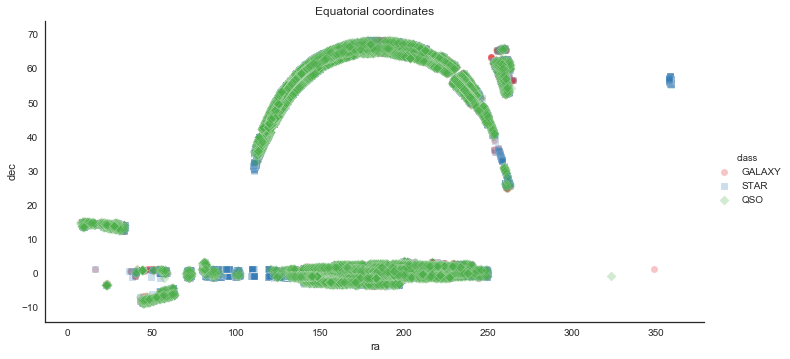

In [209]:
sns.pairplot(x_vars='ra', y_vars='dec', data=sdss_data, hue='class',palette="Set1", size=5,
             aspect=2,markers=["o", "s", "D"],plot_kws={'alpha': 0.25})
plt.title('Equatorial coordinates')

Looking at the above plot of right ascention and declination for each of our class types, we see that there is no clear seperation in the positions of our objects. We can conclude that these features will not add any real predictive value to our model and therefore we can feel confident in dropping them from our dataset.

In [9]:
sdss_features = sdss_features.drop(['ra','dec'],axis=1)

In [10]:
sdss_features.head()

,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z,redshift
0,20.21815,22.58140,20.89326,19.72453,19.39296,0.772647
1,19.25371,17.32661,16.35287,15.97924,15.70117,0.101993
2,20.01399,23.60228,21.05048,19.80330,20.26079,0.626115
3,20.26900,22.00403,20.04710,19.22714,18.37577,0.416734
4,20.56829,19.28037,18.67816,18.48124,18.32403,0.000386


Now are dataset is only in terms of frequency filters and redshift.

### Redshift

Looking at the redshift for each class of object, we see that the further away an object is the more redshifted it appears.  From these graphs, it looks like the redshift will be an important feature in classifying observations. 

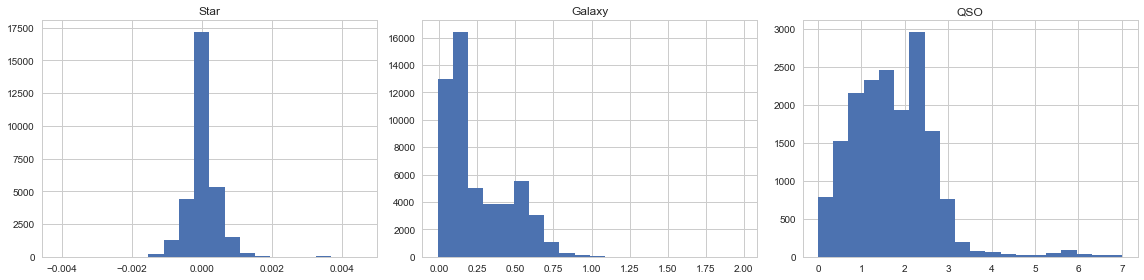

In [170]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
ax0, ax1, ax2 = axes.flatten()

n_bins = 20
x = sdss_data[sdss_data['class']=='STAR'].redshift
y = sdss_data[sdss_data['class']=='GALAXY'].redshift
z = sdss_data[sdss_data['class']=='QSO'].redshift

ax0.hist(x, bins = n_bins)
ax0.set_title('Star')

ax1.hist(y, bins = n_bins)
ax1.set_title('Galaxy')

ax2.hist(z, bins = n_bins)
ax2.set_title('QSO')

fig.tight_layout()
plt.show()

The plots above confirm our intuition that the further an object is from the observer, the more redshifted it will be.  Redshift will be a good predictor value but unfortunately, there is a bit of overlap between the reshift of some galaxies and some QSO's.

### Feature Corrolation Plot:

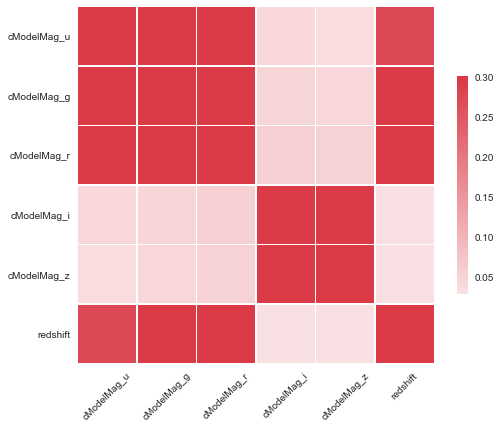

In [228]:
sns.set(style="white")

# Compute the correlation matrix
corr = sdss_features.corr()

# Set up the matplotlib figure
fig, axes = plt.subplots(figsize=(8, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.yticks(rotation=0)
plt.xticks(rotation=45)

plt.show()

We can see some correlation between the cModelMagnitudes for the u,g, and r filters as well as between the i and z filters.  There also seems to be some correlation between the cModelMagnitudes for the u,g, and r filters and redshift.

In [13]:
sdss_standardized_features = preprocessing.StandardScaler().fit(sdss_features).transform(sdss_features)
features = np.array(sdss_standardized_features)
targets = np.array(sdss_targets)

#### Split the data into test and training subsets

In [14]:
training_data, test_data, training_targets, test_targets = train_test_split(features, targets, test_size=0.25, random_state=42)

#### Encode the targets.  XGBoost cannot use string classes directly

In [15]:
# encode string class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(training_targets.ravel())
training_targets = label_encoder.transform(training_targets.ravel())
label_encoder = label_encoder.fit(test_targets.ravel())
test_targets = label_encoder.transform(test_targets.ravel())

#### Define a basic XGBoost classifier

In [18]:
# max_delta_step set to one since we have an embalance in classes.  Can help with convergence.
xgb = XGBClassifier(max_delta_step=1,random_state=42)

#### Fitting an XGBoost model with default parameters

In [19]:
xgb.fit(training_data, training_targets)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=1,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Above we see the default parameters used by the classifier.

#### Make prediction and look at the accuracy

In [20]:
predictions = xgb.predict(test_data)
xgb_accuracy = (predictions == test_targets).sum().astype(float) / len(predictions)*100
print("XGBoost's prediction accuracy is: %3.2f" % (xgb_accuracy))

XGBoost's prediction accuracy is: 97.64


#### Use sklearn's RandomizedSearchCV to try and tune some parameters

In [98]:
n_estimators = range(800,1600,100)
max_tree_depth = [8] #range(3,9)
eta = [0.1] #[0.01,0.05,0.1,0.5,1] #learning rate
lmbda = [1,2,3,4] #[0.5,1,2]  #L2 regularization term on weights
min_child_wt = [1,2,3]
gamma = [0,0.1,0.5] #[0,1,2,4]  #Minimum loss reduction required to make a further partition on a leaf node of the tree.

In [99]:
xgbParams = {
    'learning_rate':eta,
    'gamma':gamma,
    'n_estimators':n_estimators,
    'reg_lambda':lmbda,
    'max_depth':max_tree_depth,
    'min_child_weight':min_child_wt
}

In [100]:
clf = RandomizedSearchCV(xgb,xgbParams)

In [101]:
clf.fit(training_data, training_targets)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=1,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'learning_rate': [0.1], 'gamma': [0, 0.1, 0.5], 'n_estimators': range(800, 1600, 100), 'reg_lambda': [1, 2, 3, 4], 'max_depth': [8], 'min_child_weight': [1, 2, 3]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [102]:
clf_best_parameters = clf.best_estimator_
print(clf_best_parameters)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.5, learning_rate=0.1, max_delta_step=1,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=900,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=42,
       reg_alpha=0, reg_lambda=2, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [103]:
preds = clf.predict(test_data)

In [104]:
xgb_accuracy = (preds == test_targets).sum().astype(float) / len(preds)*100
print("XGBoost's prediction accuracy is: %3.2f" % (xgb_accuracy))

XGBoost's prediction accuracy is: 98.19


We achieve a slight improvement by searching over a range of parameter values to try to hypertune the learning parameters of the model.

#### The Confusion Matrix

In [42]:
from sklearn.metrics import confusion_matrix
import itertools

In [105]:
cm = confusion_matrix(test_targets, preds)
classes = label_encoder.inverse_transform(test_targets)
classes = np.unique(classes)

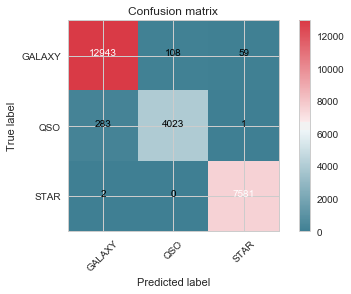

In [106]:
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

#fmt = '.2f'
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

The results are in line with what we saw in the redshift plots for the different classes of objects. Galaxies and QSO's are much harder to differentiate.

We have used the XGBoost classifier to predict with 98 percent accuracy the class (type) of stellar object for a given SDSS observation.  Further hypertuning of parameters might acheive a slight increase in accuracy but further research into the features available in the data would probably be the best way to increase accuracy of the model in its ability to differentiate galaxies from QSO's.